Using seaborn style.

--- Processing dataset: gpqa_diamond ---
--- Processing model: QwQ-32B for dataset gpqa_diamond ---
Processed QwQ-32B, dataset gpqa_diamond, 1: Found 198 rows. Accuracy = 0.6313
Processed QwQ-32B, dataset gpqa_diamond, 2: Found 198 rows. Accuracy = 0.6212
Processed QwQ-32B, dataset gpqa_diamond, 8: Found 198 rows. Accuracy = 0.6515
Processed QwQ-32B, dataset gpqa_diamond, 16: Found 198 rows. Accuracy = 0.6818
Processed QwQ-32B, dataset gpqa_diamond, 32: Found 198 rows. Accuracy = 0.6717
--- Processing model: R1-Distill-Qwen-14B for dataset gpqa_diamond ---
Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 1: Found 198 rows. Accuracy = 0.5960
Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 2: Found 198 rows. Accuracy = 0.5505
Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 8: Found 198 rows. Accuracy = 0.6313
Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 16: Found 198 rows. Accuracy = 0.6061
Processed R1-Distill-Qwen-14B, dataset gpqa_diamond, 3

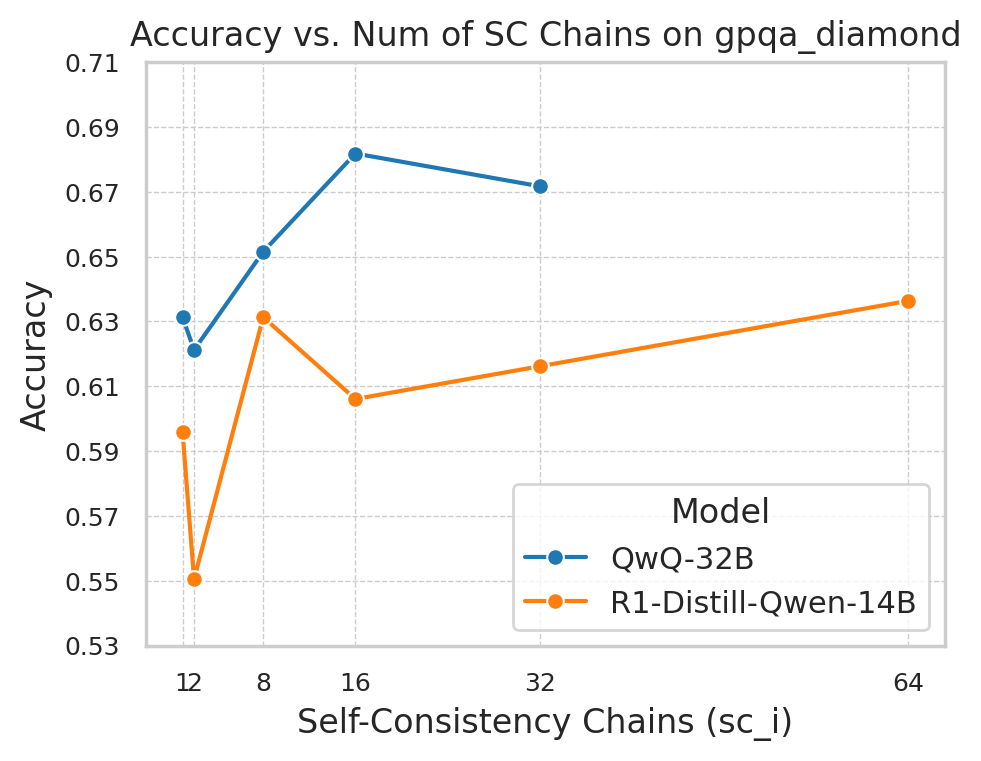


--- Processing dataset: aime ---
--- Processing model: QwQ-32B for dataset aime ---
Processed QwQ-32B, dataset aime, 1: Found 30 rows. Accuracy = 0.8000
Processed QwQ-32B, dataset aime, 2: Found 30 rows. Accuracy = 0.8000
Processed QwQ-32B, dataset aime, 8: Found 29 rows. Accuracy = 0.8621
Processed QwQ-32B, dataset aime, 16: Found 30 rows. Accuracy = 0.8333
--- Processing model: R1-Distill-Qwen-14B for dataset aime ---
Processed R1-Distill-Qwen-14B, dataset aime, 1: Found 30 rows. Accuracy = 0.7333
Processed R1-Distill-Qwen-14B, dataset aime, 2: Found 30 rows. Accuracy = 0.6333
Processed R1-Distill-Qwen-14B, dataset aime, 8: Found 30 rows. Accuracy = 0.8000
Processed R1-Distill-Qwen-14B, dataset aime, 16: Found 30 rows. Accuracy = 0.7667
Processed R1-Distill-Qwen-14B, dataset aime, 32: Found 30 rows. Accuracy = 0.8000
Processed R1-Distill-Qwen-14B, dataset aime, 64: Found 30 rows. Accuracy = 0.8333

--- Calculated Accuracies for aime ---
              model sc_label  accuracy
       

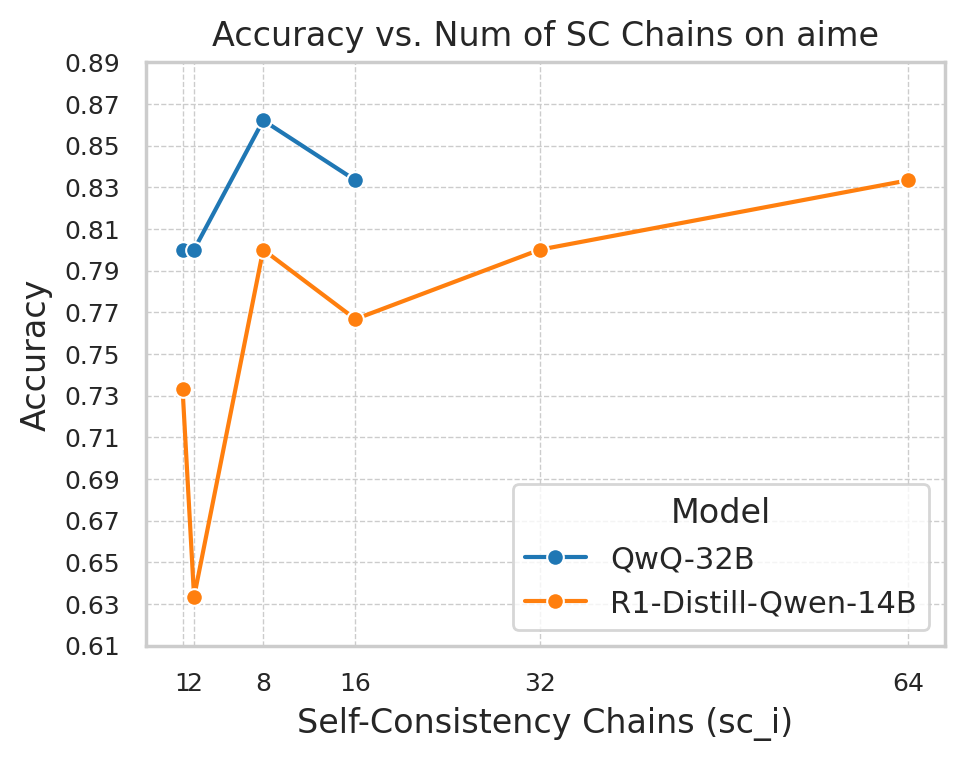


--- Processing dataset: aqua_rat ---
--- Processing model: QwQ-32B for dataset aqua_rat ---
Processed QwQ-32B, dataset aqua_rat, 1: Found 254 rows. Accuracy = 0.9055
Processed QwQ-32B, dataset aqua_rat, 2: Found 254 rows. Accuracy = 0.9213
Processed QwQ-32B, dataset aqua_rat, 8: Found 254 rows. Accuracy = 0.9173
Processed QwQ-32B, dataset aqua_rat, 16: Found 254 rows. Accuracy = 0.9134
Processed QwQ-32B, dataset aqua_rat, 32: Found 254 rows. Accuracy = 0.9173
--- Processing model: R1-Distill-Qwen-14B for dataset aqua_rat ---
Processed R1-Distill-Qwen-14B, dataset aqua_rat, 1: Found 254 rows. Accuracy = 0.9016
Processed R1-Distill-Qwen-14B, dataset aqua_rat, 2: Found 254 rows. Accuracy = 0.8898
Processed R1-Distill-Qwen-14B, dataset aqua_rat, 8: Found 254 rows. Accuracy = 0.9094
Processed R1-Distill-Qwen-14B, dataset aqua_rat, 16: Found 254 rows. Accuracy = 0.9055
Processed R1-Distill-Qwen-14B, dataset aqua_rat, 32: Found 254 rows. Accuracy = 0.8976
Processed R1-Distill-Qwen-14B, datas

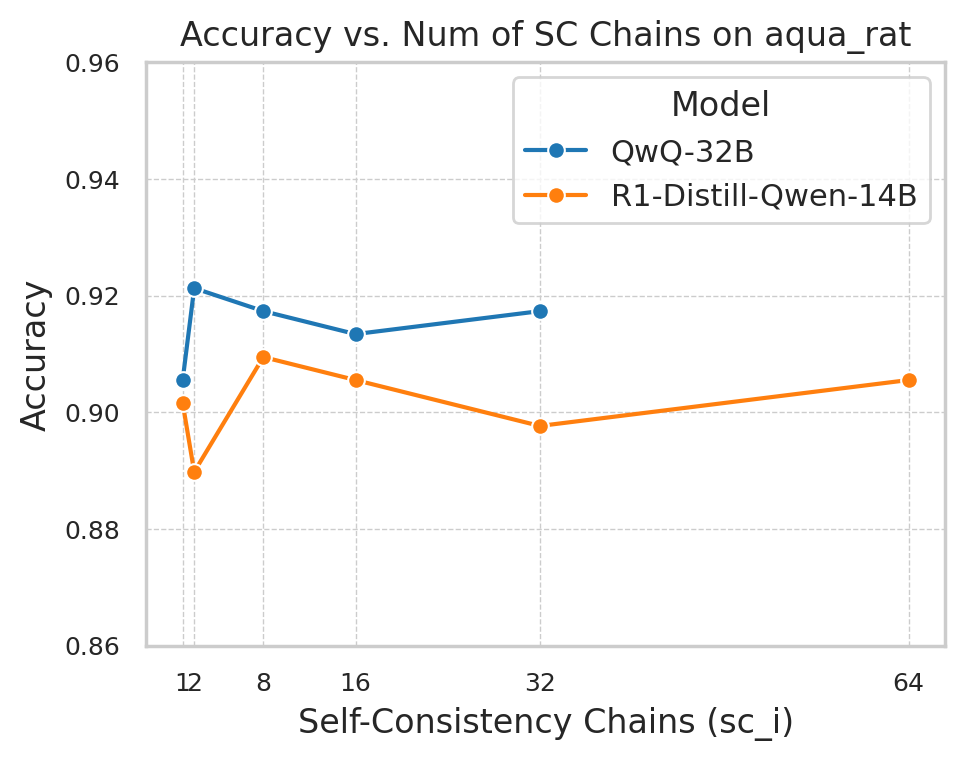


--- Finished processing all datasets ---


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import seaborn as sns # For nicer plots
import numpy as np

# Configure matplotlib for better display
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cm.tab10.colors)

# --- Configuration ---

# Define the models and their respective ROOT paths (before dataset name)
models_config = {
    "QwQ-32B": "/home/users/ntu/chong032/slimsc/prune/results/QwQ-32B/",
    "R1-Distill-Qwen-14B": "/home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/",
}

# Define the benchmark datasets to process
datasets_to_process = ["gpqa_diamond", "aime", "aqua_rat"] # Add your datasets here

# Define the sc_i values to compare
sc_i_values = [1, 2, 8, 16, 32, 64]
file_name = "evaluation_summary.csv"

# Configure seaborn style once
try:
    sns.set_theme(style="whitegrid")
    print("Using seaborn style.")
except ImportError:
    print("Seaborn not installed, using default matplotlib style.")

# --- Data Collection and Plotting per Dataset ---

for dataset_name in datasets_to_process:
    print(f"\n--- Processing dataset: {dataset_name} ---")

    all_results_list_for_this_dataset = []

    for model_name, model_root_path in models_config.items():
        print(f"--- Processing model: {model_name} for dataset {dataset_name} ---")

        # Construct the base path for this model and dataset
        base_path = os.path.join(model_root_path, dataset_name)

        for i in sc_i_values:
            experiment_folder = f"sc_{i}_control"
            full_path = os.path.join(base_path, experiment_folder, file_name)

            label = f"{i}"

            if not os.path.exists(full_path):
                print(f"WARNING: File not found for {model_name}, dataset {dataset_name}, {label}: {full_path}")
                continue

            try:
                df = pd.read_csv(full_path)

                if df.empty:
                    print(f"WARNING: DataFrame is empty for {model_name}, dataset {dataset_name}, {label}: {full_path}")
                    accuracy = 0.0 # Or float('nan') if you prefer to exclude
                else:
                    # Use all data
                    accuracy = df['final_score'].mean()

                # Store the result
                all_results_list_for_this_dataset.append({
                    'model': model_name,
                    'sc_value': i,       # Store numeric value for sorting/plotting
                    'sc_label': label,   # Store string label for x-ticks
                    'accuracy': accuracy
                })

                print(f"Processed {model_name}, dataset {dataset_name}, {label}: Found {len(df)} rows. Accuracy = {accuracy:.4f}")

            except Exception as e:
                print(f"ERROR processing file {full_path}: {e}")

    # --- Plotting for the current dataset ---

    if not all_results_list_for_this_dataset:
         print(f"No data collected for dataset {dataset_name}. Skipping plot.")
         continue

    # Convert the list of dictionaries to a Pandas DataFrame for this dataset
    results_df_this_dataset = pd.DataFrame(all_results_list_for_this_dataset)

    # Sort by sc_value to ensure line points are connected in the correct order
    results_df_this_dataset = results_df_this_dataset.sort_values(by='sc_value')

    print(f"\n--- Calculated Accuracies for {dataset_name} ---")
    print(results_df_this_dataset[['model', 'sc_label', 'accuracy']].to_string(index=False))

    # Create a new figure for each dataset
    plt.figure(figsize=(5, 4)) # Slightly larger figure

    # Create the line plot using seaborn
    lineplot = sns.lineplot(
        x='sc_value',      # Use numeric value for line plotting
        y='accuracy',
        hue='model',       # Different color line for each model
        marker='o',        # Add circles at each data point
        data=results_df_this_dataset,
        palette="tab10"
    )

    # Manually set x-ticks to use the sc_label strings and corresponding positions
    plt.xticks(results_df_this_dataset['sc_value'].unique(), results_df_this_dataset['sc_label'].unique(), fontsize=9)


    plt.xlabel("Self-Consistency Chains (sc_i)")
    plt.ylabel("Accuracy")
    # Dynamic title based on dataset name
    plt.title(f"Accuracy vs. Num of SC Chains on {dataset_name}")

    # Set y-ticks dynamically based on the data range for this dataset
    min_acc = results_df_this_dataset['accuracy'].min()
    max_acc = results_df_this_dataset['accuracy'].max()
    # Create a slightly padded range for y-ticks
    plt.yticks(np.arange(max(0, np.floor(min_acc*100)/100 - 0.02), # Ensure lower bound isn't negative
               np.ceil(max_acc*100)/100 + 0.03,
               0.02), fontsize=9) # Adjust step as needed

    plt.legend(title="Model") # Add a legend
    plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Add a grid for readability
    plt.tight_layout() # Adjust plot to ensure everything fits

    plt.show() # Display the plot for the current dataset

    # Optional: Save the plot to a file (uncomment to enable)
    # plot_filename = f'accuracy_vs_sc_{dataset_name}.png'
    # plt.savefig(plot_filename, dpi=300)
    # print(f"Saved plot to {plot_filename}")
    # plt.close() # Close the figure after saving to free memory if you don't show


print("\n--- Finished processing all datasets ---")